# RSA Encryption: Mathematical Foundations and Implementation

## Introduction

RSA (Rivest-Shamir-Adleman) is one of the first public-key cryptosystems and remains widely used for secure data transmission. The security of RSA relies on the practical difficulty of factoring the product of two large prime numbers—the **factoring problem**.

## Mathematical Foundation

### Key Generation

The RSA algorithm begins with key generation:

1. **Select two distinct prime numbers** $p$ and $q$

2. **Compute the modulus** $n$:
   $$n = p \cdot q$$

3. **Compute Euler's totient function** $\phi(n)$:
   $$\phi(n) = (p-1)(q-1)$$
   
   This counts the number of integers less than $n$ that are coprime to $n$.

4. **Choose the public exponent** $e$ such that:
   - $1 < e < \phi(n)$
   - $\gcd(e, \phi(n)) = 1$
   
   Common choices are $e = 65537 = 2^{16} + 1$ (a Fermat prime).

5. **Compute the private exponent** $d$ as the modular multiplicative inverse of $e$ modulo $\phi(n)$:
   $$d \equiv e^{-1} \pmod{\phi(n)}$$
   
   This means: $e \cdot d \equiv 1 \pmod{\phi(n)}$

### Key Distribution

- **Public Key**: $(n, e)$ — shared openly
- **Private Key**: $(n, d)$ — kept secret

### Encryption

Given a plaintext message $m$ (where $0 \leq m < n$), the ciphertext $c$ is computed as:
$$c \equiv m^e \pmod{n}$$

### Decryption

The original message is recovered from the ciphertext using:
$$m \equiv c^d \pmod{n}$$

### Correctness Proof

The decryption works because of **Euler's theorem**. For any integer $a$ coprime to $n$:
$$a^{\phi(n)} \equiv 1 \pmod{n}$$

Since $e \cdot d \equiv 1 \pmod{\phi(n)}$, we can write $e \cdot d = 1 + k \cdot \phi(n)$ for some integer $k$.

Therefore:
$$c^d \equiv (m^e)^d \equiv m^{ed} \equiv m^{1 + k\phi(n)} \equiv m \cdot (m^{\phi(n)})^k \equiv m \cdot 1^k \equiv m \pmod{n}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import gcd
import random

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

## Implementation

### Utility Functions

We first implement the necessary mathematical utilities for RSA.

In [2]:
def is_prime(n, k=10):
    """
    Miller-Rabin primality test.
    
    Tests if n is probably prime with error probability < 4^(-k).
    """
    if n < 2:
        return False
    if n == 2 or n == 3:
        return True
    if n % 2 == 0:
        return False
    
    # Write n-1 as 2^r * d
    r, d = 0, n - 1
    while d % 2 == 0:
        r += 1
        d //= 2
    
    # Witness loop
    for _ in range(k):
        a = random.randrange(2, n - 1)
        x = pow(a, d, n)
        
        if x == 1 or x == n - 1:
            continue
        
        for _ in range(r - 1):
            x = pow(x, 2, n)
            if x == n - 1:
                break
        else:
            return False
    
    return True


def generate_prime(bits):
    """
    Generate a random prime number with specified bit length.
    """
    while True:
        # Generate random odd number with correct bit length
        n = random.getrandbits(bits)
        n |= (1 << bits - 1) | 1  # Set MSB and LSB
        
        if is_prime(n):
            return n


def extended_gcd(a, b):
    """
    Extended Euclidean Algorithm.
    
    Returns (gcd, x, y) such that a*x + b*y = gcd(a, b)
    """
    if a == 0:
        return b, 0, 1
    
    gcd_val, x1, y1 = extended_gcd(b % a, a)
    x = y1 - (b // a) * x1
    y = x1
    
    return gcd_val, x, y


def mod_inverse(e, phi):
    """
    Compute modular multiplicative inverse of e modulo phi.
    
    Returns d such that (e * d) % phi = 1
    """
    gcd_val, x, _ = extended_gcd(e % phi, phi)
    
    if gcd_val != 1:
        raise ValueError("Modular inverse does not exist")
    
    return (x % phi + phi) % phi

### RSA Key Generation

In [3]:
def generate_rsa_keys(bits=512):
    """
    Generate RSA public and private key pairs.
    
    Parameters:
        bits: Bit length for each prime (total key size is 2*bits)
        
    Returns:
        public_key: (n, e)
        private_key: (n, d)
        key_components: dict with p, q, phi for educational purposes
    """
    # Step 1: Generate two distinct primes
    p = generate_prime(bits)
    q = generate_prime(bits)
    
    while p == q:
        q = generate_prime(bits)
    
    # Step 2: Compute n = p * q
    n = p * q
    
    # Step 3: Compute Euler's totient
    phi = (p - 1) * (q - 1)
    
    # Step 4: Choose public exponent e
    e = 65537  # Standard choice (Fermat prime F4)
    
    # Verify e is coprime to phi
    if gcd(e, phi) != 1:
        # Fallback: find suitable e
        e = 3
        while gcd(e, phi) != 1:
            e += 2
    
    # Step 5: Compute private exponent d
    d = mod_inverse(e, phi)
    
    public_key = (n, e)
    private_key = (n, d)
    key_components = {'p': p, 'q': q, 'phi': phi, 'n': n, 'e': e, 'd': d}
    
    return public_key, private_key, key_components


# Generate keys with smaller bit size for demonstration
public_key, private_key, components = generate_rsa_keys(bits=64)

print("=== RSA Key Generation ===")
print(f"\nPrime p: {components['p']}")
print(f"Prime q: {components['q']}")
print(f"\nModulus n = p × q: {components['n']}")
print(f"Euler's totient φ(n) = (p-1)(q-1): {components['phi']}")
print(f"\nPublic exponent e: {components['e']}")
print(f"Private exponent d: {components['d']}")
print(f"\nPublic Key (n, e): ({public_key[0]}, {public_key[1]})")
print(f"Private Key (n, d): ({private_key[0]}, {private_key[1]})")

# Verify: e * d ≡ 1 (mod φ(n))
verification = (components['e'] * components['d']) % components['phi']
print(f"\nVerification: e × d mod φ(n) = {verification} (should be 1)")

=== RSA Key Generation ===

Prime p: 16231793829986840849
Prime q: 16412302689830747053

Modulus n = p × q: 266401113536671151789822894025086767997
Euler's totient φ(n) = (p-1)(q-1): 266401113536671151757178797505269180096

Public exponent e: 65537
Private exponent d: 29397330562845503601140074516046000129

Public Key (n, e): (266401113536671151789822894025086767997, 65537)
Private Key (n, d): (266401113536671151789822894025086767997, 29397330562845503601140074516046000129)

Verification: e × d mod φ(n) = 1 (should be 1)


### RSA Encryption and Decryption

In [4]:
def rsa_encrypt(message, public_key):
    """
    Encrypt a message using RSA public key.
    
    c = m^e mod n
    """
    n, e = public_key
    
    if message >= n:
        raise ValueError(f"Message {message} must be less than n={n}")
    
    ciphertext = pow(message, e, n)
    return ciphertext


def rsa_decrypt(ciphertext, private_key):
    """
    Decrypt a ciphertext using RSA private key.
    
    m = c^d mod n
    """
    n, d = private_key
    message = pow(ciphertext, d, n)
    return message


# Demonstration with a simple numeric message
original_message = 12345678901234567

print("=== RSA Encryption/Decryption Demo ===")
print(f"\nOriginal message: {original_message}")

# Encrypt
ciphertext = rsa_encrypt(original_message, public_key)
print(f"Ciphertext (m^e mod n): {ciphertext}")

# Decrypt
decrypted_message = rsa_decrypt(ciphertext, private_key)
print(f"Decrypted message (c^d mod n): {decrypted_message}")

# Verify
print(f"\nDecryption successful: {original_message == decrypted_message}")

=== RSA Encryption/Decryption Demo ===

Original message: 12345678901234567
Ciphertext (m^e mod n): 251958991044433804335731620076878759450
Decrypted message (c^d mod n): 12345678901234567

Decryption successful: True


### Text Message Encryption

To encrypt text, we convert it to integers and handle messages longer than $n$ by chunking.

In [5]:
def text_to_int(text):
    """Convert text to integer using UTF-8 encoding."""
    return int.from_bytes(text.encode('utf-8'), 'big')


def int_to_text(number):
    """Convert integer back to text."""
    byte_length = (number.bit_length() + 7) // 8
    return number.to_bytes(byte_length, 'big').decode('utf-8')


def encrypt_text(text, public_key):
    """Encrypt a text message."""
    message_int = text_to_int(text)
    n, e = public_key
    
    if message_int >= n:
        raise ValueError("Message too long for this key size. Use larger keys or chunk the message.")
    
    return rsa_encrypt(message_int, public_key)


def decrypt_text(ciphertext, private_key):
    """Decrypt to get original text."""
    message_int = rsa_decrypt(ciphertext, private_key)
    return int_to_text(message_int)


# Demo with a short text message
secret_message = "RSA!"

print("=== Text Encryption Demo ===")
print(f"\nOriginal text: '{secret_message}'")
print(f"As integer: {text_to_int(secret_message)}")

encrypted = encrypt_text(secret_message, public_key)
print(f"Encrypted: {encrypted}")

decrypted = decrypt_text(encrypted, private_key)
print(f"Decrypted: '{decrypted}'")

=== Text Encryption Demo ===

Original text: 'RSA!'
As integer: 1381187873
Encrypted: 226683925327576731659371201336279281045
Decrypted: 'RSA!'


## Security Analysis

### Computational Complexity

The security of RSA relies on the **integer factorization problem**. While multiplication is easy:
$$n = p \times q \quad \text{(polynomial time)}$$

Factoring $n$ back into $p$ and $q$ is computationally hard for large $n$:
$$n \rightarrow (p, q) \quad \text{(sub-exponential time)}$$

The best known classical algorithm (General Number Field Sieve) has complexity:
$$O\left(\exp\left(\left(\frac{64}{9}\right)^{1/3} (\ln n)^{1/3} (\ln \ln n)^{2/3}\right)\right)$$

In [6]:
import time

def measure_rsa_performance(bit_sizes):
    """
    Measure RSA key generation and encryption/decryption times
    for different key sizes.
    """
    results = {
        'bits': [],
        'keygen_time': [],
        'encrypt_time': [],
        'decrypt_time': []
    }
    
    for bits in bit_sizes:
        print(f"Testing {bits*2}-bit RSA...")
        
        # Key generation timing
        start = time.time()
        pub, priv, _ = generate_rsa_keys(bits)
        keygen_time = time.time() - start
        
        # Generate test message
        test_message = random.getrandbits(bits - 1)
        
        # Encryption timing (average over multiple runs)
        num_trials = 100
        start = time.time()
        for _ in range(num_trials):
            cipher = rsa_encrypt(test_message, pub)
        encrypt_time = (time.time() - start) / num_trials
        
        # Decryption timing
        start = time.time()
        for _ in range(num_trials):
            plain = rsa_decrypt(cipher, priv)
        decrypt_time = (time.time() - start) / num_trials
        
        results['bits'].append(bits * 2)
        results['keygen_time'].append(keygen_time)
        results['encrypt_time'].append(encrypt_time * 1000)  # Convert to ms
        results['decrypt_time'].append(decrypt_time * 1000)
    
    return results


# Test different key sizes
bit_sizes = [32, 64, 128, 256, 512]
perf_results = measure_rsa_performance(bit_sizes)

print("\n=== Performance Results ===")
print(f"{'Key Size':<12} {'KeyGen (s)':<15} {'Encrypt (ms)':<15} {'Decrypt (ms)':<15}")
print("-" * 57)
for i in range(len(perf_results['bits'])):
    print(f"{perf_results['bits'][i]:<12} {perf_results['keygen_time'][i]:<15.4f} "
          f"{perf_results['encrypt_time'][i]:<15.4f} {perf_results['decrypt_time'][i]:<15.4f}")

Testing 64-bit RSA...
Testing 128-bit RSA...
Testing 256-bit RSA...
Testing 512-bit RSA...
Testing 1024-bit RSA...



=== Performance Results ===
Key Size     KeyGen (s)      Encrypt (ms)    Decrypt (ms)   
---------------------------------------------------------
64           0.0002          0.0016          0.0081         
128          0.0009          0.0063          0.0295         
256          0.0008          0.0056          0.1120         
512          0.0175          0.0140          0.5696         
1024         0.0752          0.0397          3.1500         


## Visualization

Let's visualize the performance characteristics of RSA with different key sizes.

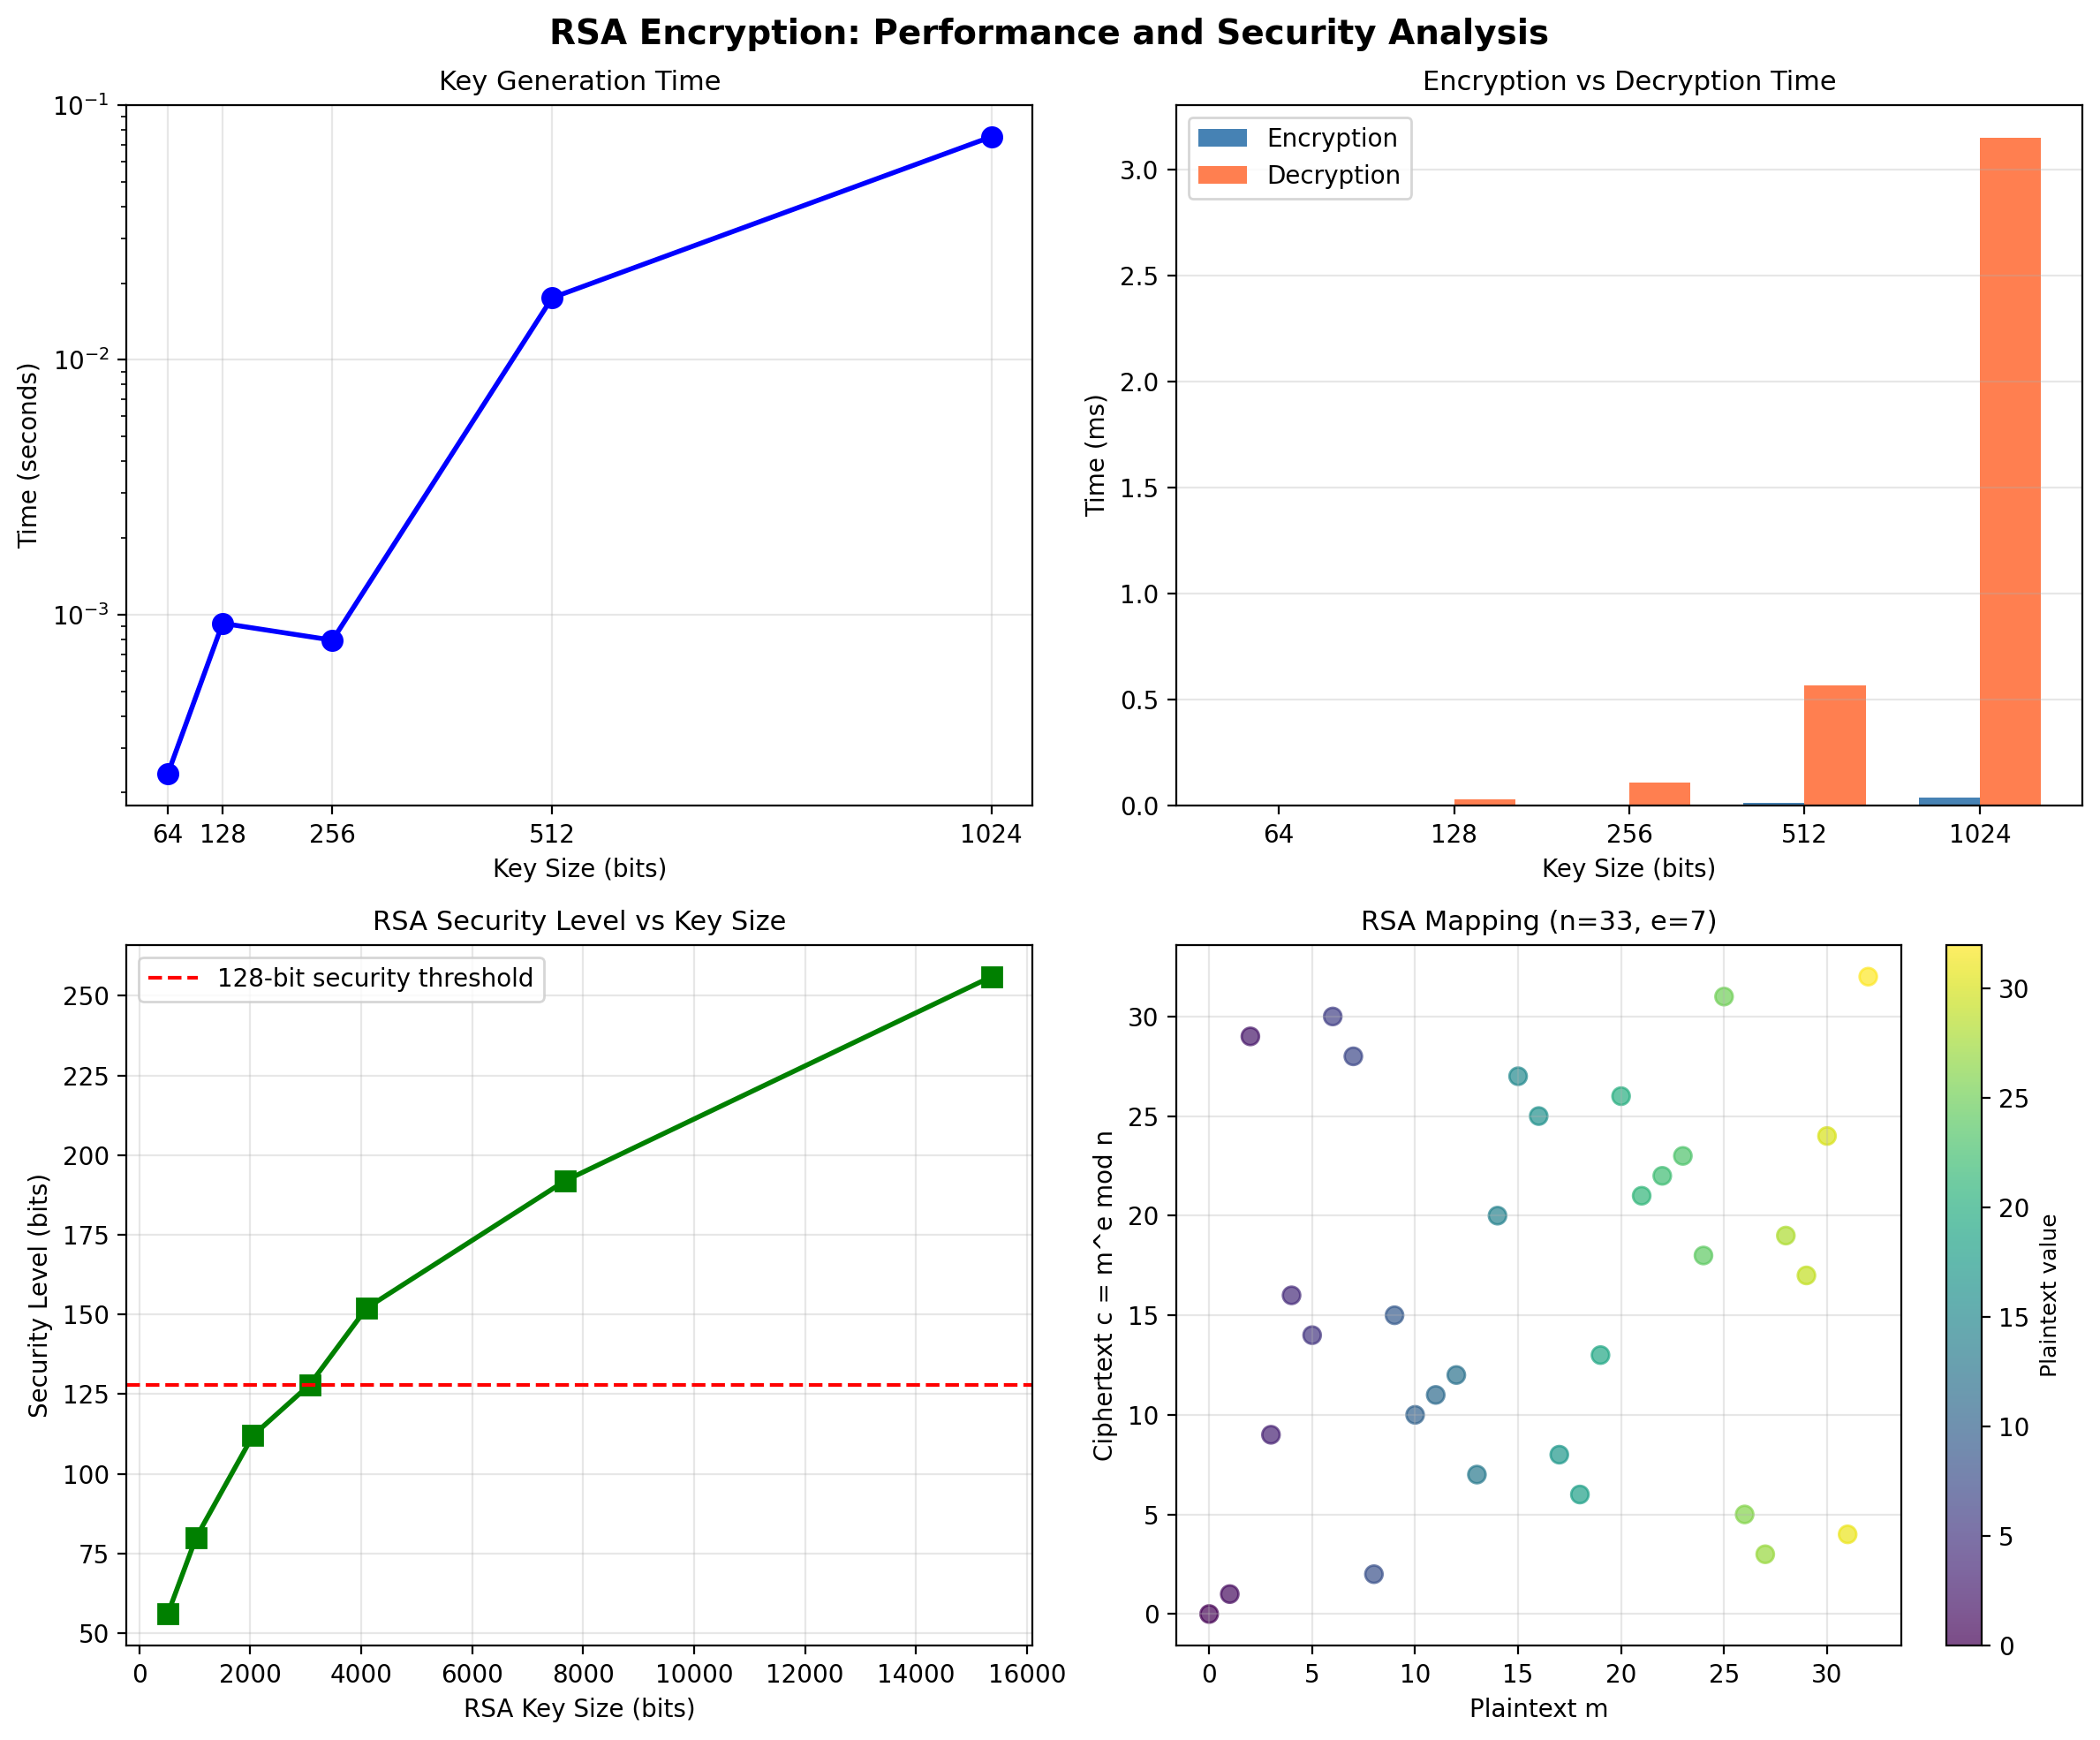


Plot saved to 'plot.png'


In [7]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('RSA Encryption: Performance and Security Analysis', fontsize=14, fontweight='bold')

# Plot 1: Key Generation Time
ax1 = axes[0, 0]
ax1.semilogy(perf_results['bits'], perf_results['keygen_time'], 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Key Size (bits)', fontsize=10)
ax1.set_ylabel('Time (seconds)', fontsize=10)
ax1.set_title('Key Generation Time', fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(perf_results['bits'])

# Plot 2: Encryption vs Decryption Time
ax2 = axes[0, 1]
x = np.arange(len(perf_results['bits']))
width = 0.35
bars1 = ax2.bar(x - width/2, perf_results['encrypt_time'], width, label='Encryption', color='steelblue')
bars2 = ax2.bar(x + width/2, perf_results['decrypt_time'], width, label='Decryption', color='coral')
ax2.set_xlabel('Key Size (bits)', fontsize=10)
ax2.set_ylabel('Time (ms)', fontsize=10)
ax2.set_title('Encryption vs Decryption Time', fontsize=11)
ax2.set_xticks(x)
ax2.set_xticklabels(perf_results['bits'])
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Security Level (bits of security)
ax3 = axes[1, 0]
# Approximate security levels for RSA key sizes
key_sizes = [512, 1024, 2048, 3072, 4096, 7680, 15360]
security_bits = [56, 80, 112, 128, 152, 192, 256]
ax3.plot(key_sizes, security_bits, 'gs-', linewidth=2, markersize=8)
ax3.axhline(y=128, color='r', linestyle='--', label='128-bit security threshold')
ax3.set_xlabel('RSA Key Size (bits)', fontsize=10)
ax3.set_ylabel('Security Level (bits)', fontsize=10)
ax3.set_title('RSA Security Level vs Key Size', fontsize=11)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Modular Exponentiation Visualization
ax4 = axes[1, 1]
# Show how m^e mod n behaves for small example
small_n = 33  # 3 * 11
small_e = 7
messages = list(range(small_n))
ciphertexts = [pow(m, small_e, small_n) for m in messages]

ax4.scatter(messages, ciphertexts, c=messages, cmap='viridis', s=50, alpha=0.7)
ax4.set_xlabel('Plaintext m', fontsize=10)
ax4.set_ylabel('Ciphertext c = m^e mod n', fontsize=10)
ax4.set_title(f'RSA Mapping (n={small_n}, e={small_e})', fontsize=11)
ax4.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(ax4.collections[0], ax=ax4)
cbar.set_label('Plaintext value', fontsize=9)

plt.tight_layout()
plt.savefig('rsa_encryption_basics_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## Key Observations

### Performance Characteristics

1. **Key Generation**: Time grows rapidly with key size due to primality testing
2. **Encryption**: Relatively fast due to small public exponent $e = 65537$
3. **Decryption**: Slower than encryption because $d$ is much larger than $e$

### Security Recommendations

- **Minimum recommended key size**: 2048 bits (≈112 bits of security)
- **For long-term security**: 3072+ bits (≈128 bits of security)
- **Quantum threat**: RSA will be broken by Shor's algorithm on quantum computers

### Practical Considerations

In practice, RSA is typically used for:
- **Key exchange**: Encrypt a symmetric key (e.g., AES key)
- **Digital signatures**: Sign message hashes
- **Not for bulk encryption**: Too slow; use hybrid encryption instead

## Conclusion

RSA remains a cornerstone of modern cryptography despite being developed in 1977. Its security rests on firm mathematical foundations—the difficulty of factoring large numbers. Understanding RSA provides essential insights into:

- Public-key cryptography concepts
- Number theory applications (Euler's theorem, modular arithmetic)
- Computational complexity in security

While post-quantum cryptography will eventually replace RSA, its elegant mathematical structure continues to make it invaluable for education and many current applications.